In [34]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Decomposition function

This function is used to decompact a fully compacted sedimentary package based on 2 iterations.

### Input

- `d1` : thickness of overlying (decompacted) sediment package starts at depth = 0
- `d2` : observed thickness of the underlying sediment package
- `por` : initial porosity of a particular lithology at the surface
- `ro` : sediment grain density (without water, *ie* fully compacted)
- `dm` : depth at which porosity goes to sero for given lithology
- `rhow,rhom`: density of water and mantle respectively

### Output
- `td` : decompacted sediment thickness
- `den` : decompacted sediment density
- `zw` : tectonic subsidence in water due to replacement of decompacted sediment column with water and removal of the isostatic effect of sediments - this does not include global sealevel changes or water depth estimates



In [125]:
def decomp(d1,d2,por,ro,dm,rhow,rhom):

    # Defining top (z1) and bottom (z2) depths of package
    z2 = d1+d2
    z1 = d1

    # Defining the thickness of the slab
    zs = np.sqrt(pow(z2-z1,2))

    # Calculating the decompaction 
    for m in range(2):
        # Variables for the first iteration
        avp = por*(1.0-(z1+z2)/(2*dm))
        dro = ro*(1.0-avp)+rhow*avp
        v1 = zs*(1.0+(avp/(1.0-avp)))
   
        # Redefining z2 and por variables for the next iteration
        z2 = v1+z1
        por = avp
   
    # Replace the decompacted sediment column 
    # with water and isostatically compensate for the 
    # removal of the sediments
    td = v1
    rhos = dro
    zw = td*(rhom-rhos)/(rhom-rhow)
    
    return td,rhos,zw

# Backstripping function

Now we will define the backstripping of a sedimentary column to determine decompacted thickness and tectonic subsidence. 

The backstripping depends on the previously defined function `decomp` which decompacts individual layers from a fully compacted state (zero porosity) to a given burial depth previous to reaching a fully compacted state.

The function returns the total decompacted sediment thickness and the water released at each time.

In [162]:
def backstrip(t,z,rhow,rhom):
    
    # Initalize the array of total water column at each time
    # In this case, we only consider water in pore space
    # This corresponds to tectonic subsidence in water
    subs = np.zeros(5)
    
    zsed = np.zeros(5)
    
    # Starting time loop
    # Total number of layers: 4
    for i in range(1,5):
        # Array for water realised
        z3 = np.zeros(5)
        # Thickness of decompacted sediment package
        z2a = 0. # set at 0 at start
        
        # Starting section loop
        # Number of layers at time t(i)
        zsed1 = np.zeros(5)
        for j in range(1,i+1):
            
            # assigning values to units depending on whether 
            # sedimentary unit index is odd or even (1-4). Odd 
            # corresponds to shale and even to sandstone. 
            # Here % sign is used to calculate the modulus 
            # (depending on whether unit number is odd or even)
            if (i+1-j)%2==0:
                por = 0.6
                dm = 6000
                ro = 2.72
            else:
                por = 0.25
                dm = 10000
                ro = 2.65
                            
            # Setting up d1 and d2 for each loop
            # d1 is the thickness of overlying (decompacted) sediment 
            # package (starts at depth = 0)
            # d2 is the observed thickness of the underlying sediment 
            # package
            d1 = z2a
            d2 = z[i+1-j]

            # Decompacting layer
            # td = decompacted sediment thickness
            # rhos = average decompacted sediment density of given unit
            # zw = tectonic subsidence in water due to replacement of decompacted sediment column
            #      with water and removal of the isostatic effect of sediments - this does not
            #      include global sealevel changes or water depth estimates
            td,rhos,zw = decomp(d1,d2,por,ro,dm,rhow,rhom)
    
            # Creating array of decompacted thicknesses
            zsed1[j] = td
    
            # Creating an array for the water released
            z3[j] = zw
    
            # Redefining z2a for next loop
            # (thickness of the decompacted sediment package)
            z2a = td+d1
        
        # Calculating total decompacted sediment thickness at each time
        zsed[i] = sum(zsed1)

        # Calculating the total amount of water released at each time
        zt = sum(z3)

        # Making an array of the water released at each time
        subs[i] = zt

    return subs,zsed

# Compute the backstripping of the sedimentary pile

In [165]:
# Define ages array
ages = np.zeros(5)
ages[1:5] = [142, 120, 100, 75]

# Define layers thicknesses
laythick = np.zeros(5)
laythick[1:5] = [750, 600, 650, 500]

# Densities of water (g.cm-3)
rhow = 1.03

# Densities of mantle (g.cm-3)
rhom = 3.3

# Perform backstripping 
# It will return:
# - the total decompacted sediment thickness at each time (zsed)
# - the the water released at each time (subs)
subs,zsed = backstrip(ages,laythick,rhow,rhom)

# Create final time, subsidence and sediment thickness arrays
tecsub = np.zeros(6)
t1 = np.zeros(6)
t1[1] = 150
decompthick = np.zeros(6)
decompthick[1] = 0
sed_depth = np.zeros(6)
for n in range(1,5):
    tecsub[n+1] = subs[n]
    decompthick[n+1] = zsed[n]
    t1[n+1] = ages[n]
    sed_depth[n+1] = sed_depth[n]+laythick[n]

# Plotting the results

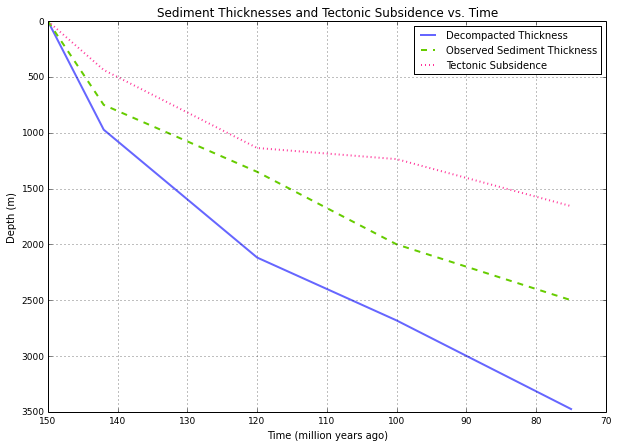

In [166]:
fig = plt.figure(figsize = (10,7))
plt.rc("font", size=9)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Sediment Thicknesses and Tectonic Subsidence vs. Time', fontsize=12)

plt.plot(t1[1:6],decompthick[1:6],'-',color='#6666FF',linewidth=2,label='Decompacted Thickness')
plt.plot(t1[1:6],sed_depth[1:6],'--',color='#66CC00',linewidth=2,label='Observed Sediment Thickness')
plt.plot(t1[1:6],tecsub[1:6],':',color='#FF3399',linewidth=2,label='Tectonic Subsidence')

axes = plt.gca().invert_xaxis()
axes = plt.gca().invert_yaxis()

axes = plt.gca()
plt.legend(loc=1, fontsize=10)
plt.grid(True)
plt.xlabel('Time (million years ago)',fontsize=10)
plt.ylabel('Depth (m)',fontsize=10)